# DHEERAJ PANNEER SELVAM

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import spatial
from sklearn import metrics
import seaborn as sns
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# Load Datasets

In [2]:
df = pd.read_csv('algerian_fires_train.csv')
df.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,01/06/2012,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,6.225461,0
1,01/06/2012,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,2.268104,0
2,02/06/2012,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,-3.327908,0
3,02/06/2012,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,0.131303,0
4,03/06/2012,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,-1.928471,0


In [3]:
dfs = df.values
X = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

In [4]:
df_t = pd.read_csv('algerian_fires_test.csv')
df_t.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,01/09/2012,15.861392,103.083493,23.929982,6.862311,18.206803,6.705575,16.934059,1.272175,1.567136,0
1,01/09/2012,25.127811,85.095686,16.066414,-0.332408,36.300922,4.307622,-8.813586,-1.707135,-2.167708,0
2,02/09/2012,25.804539,112.848312,8.603607,10.148430,32.909853,-3.989974,12.276834,0.886849,5.108220,0
3,02/09/2012,39.157179,40.359214,13.347197,-0.050950,101.833950,4.923229,17.509484,1.000106,1.990220,0
4,03/09/2012,14.943534,51.887200,14.976143,3.910505,66.608357,0.628217,17.332474,-1.773158,9.083053,0


In [5]:
dfst = df_t.values
Xt = df_t.iloc[:,1:-1].values
yt = df_t.iloc[:,-1].values

# Defining Global Functions

## To find the accuracy of model

In [6]:
def accuracy(y,yh):
    count = 0
    for i in range(len(y)):
        if y[i]==yh[i]:
            count += 1
    return count/len(y)

## Provides the Accuracy, F1 Score and Confusion matrix of model

In [7]:
def scores(yt,yh,sets):
    print(f'{sets} Accuracy = {accuracy(yt,yh)}')
    print(f' F1 Score = {metrics.f1_score(yt,yh)}')
    plt.figure()
    cm = metrics.confusion_matrix(yt,yh)
    print('\nConfusion Matrix')
    sns.set(rc = {'figure.figsize':(2,2)})
    sns.heatmap(cm,annot=True)

## Gives the indices of datapoints belonging the various classes

In [8]:
def class_ind(X,y):
    c1=[]
    c2=[]
    for i in range(len(X)):
        if y[i] == 0:
            c1.append(i)
        else:
            c2.append(i)
    return c1,c2

# Trivial Regressor

This Model doesn't use the datapoints, randomly gives output based on the overall probability of occurence of a class

## Model

In [9]:
def trivial(l,df):
    v = df['Classes'].value_counts()
    n = len(df)
    a = v[0]/n
    b = v[1]/n
    yh=random.choices([0,1],[a,b],k=l)
    return yh

# N means - Baseline Classifier

The nmeans classifier was used as a baseline or refrence classifier, to compare other models. No optimization was done on this classifier. Output labels was based on eucledian distance to the closest datapoint

## Model Function

In [10]:
def nmeans(X,y,data):
    c1=[]
    c2=[]
    for i in range(len(X)):
        if y[i] == 0:
            c1.append(i)
        else:
            c2.append(i)
    
    s1 = X[c1,:]
    s2 = X[c2,:]
    
    m1 = s1.mean(axis=0)
    m2 = s2.mean(axis=0)

    val1 = []
    val2 = []
    
    for i in data:
        val1.append(spatial.distance.euclidean(i, m1))
        val2.append(spatial.distance.euclidean(i, m2))
    
    yh = []
    for j in range(len(data)):
        if val1[j]<val2[j]:
            yh.append(0)
        else:
            yh.append(1)
    return yh

# Bayes Minimum-Error Classifier (Gaussian Distribution Model)

The 1st Classifier I will be using is the Bayes Minimum error classifier, where the decision boundry is given by
g = -(1/2)ln(|Ei|)-(1/2)(X-mi)TE/^-1(X-mi)+ln(P(Si))
This function uses the Covariance Matrix and means to predict the labels of the datapoints

## Model Function

In [11]:
def Bayes(df,X,y,Xt):
    
    c = class_ind(X,y)
    s1 = X[c[0],:]
    s2 = X[c[1],:]

    m1 = s1.mean(axis=0)
    m2 = s2.mean(axis=0)

    v = df['Classes'].value_counts()
    n = len(df)
    Ps1 = v[0]/n
    Ps2 = v[1]/n
    
    E1 = df.iloc[c[0],:-1].cov().values
    E2 = df.iloc[c[1],:-1].cov().values
    
    g11 =-0.5*math.log(np.linalg.det(E1),math.exp(1))
    g13 = math.log(Ps1,math.exp(1))
    g12 = []
    for i in range(len(Xt)):
        g12.append(((Xt-m1)[i]@np.linalg.inv(E1))@(Xt-m1)[i].T)
    g12 = -0.5*np.array(g12)
    g1 = g11+g12+g13
    
    g21 =-0.5*math.log(np.linalg.det(E2),math.exp(1))
    g23 = math.log(Ps2,math.exp(1))
    g22 = []
    for i in range(len(Xt)):
        g22.append(((Xt-m2)[i]@np.linalg.inv(E2))@(Xt-m2)[i].T)
    g22 = -0.5*np.array(g22)
    g2 = g21+g22+g23
    
    yh = []
    for j in range(len(g1)):
        if g1[j]>g2[j]:
            yh.append(0)
        else:
            yh.append(1)
    
    return yh

# Perceptron Learning Algorithm (Sequential GD and Scheduler for Eta)

## Function to claculate cost J(w)

In [12]:
def critierion_perc(w,z,x):
    val = w@x.T*z
    tot = 0
    for i in val:
        if i <= 0:
            tot = tot + i
    return -1*tot

## Function to find optimal weights and coressponing error, for each eta overall 20 combinations

In [13]:
def gradient_seq(df):
    w = np.random.uniform(-0.05,0.05,len(df[0]))

    A = [0.01, 0.1, 1, 10, 100]
    B = [1, 10, 100, 1000]
    Et = {}
    wt = {}
    

    dfl = df.tolist()
    dfs = random.sample(dfl,len(dfl))
    dfs = np.array(dfs)
    x = dfs[:,:-1]
    o = np.ones((len(x),1))
    x = np.hstack([o,x])
    y = dfs[:,-1]


    z = []
    for i in dfs[:,-1]:
        if i == 0:
            z.append(1)
        elif i == 1:
            z.append(-1)
    z = np.array(z)
    
    for a in A:
        for b in B:
            m = 0
            E = []
            while True:
                m += 1
                E.append(critierion_perc(w,z,x)**0.5)
                J = {}
                k = random.sample(range(0,len(x)),len(x))
                for n in k:
                    i = (m)*len(x)+(n+1)
                    eta = a/(b+i)
                    if w@x[n].T*z[n] <= 0:
                        w = w+(eta*z[n]*x[n])
            
                    if m >= 100:
                        wt[a,b] = w
                        Et[a,b] = E
                        break
                if m >= 100:
                    break
            
    return wt,Et

## Predict Class Labels based on optimal weights

In [14]:
def classification_perc(w,x):
    o = np.ones((len(x),1))
    x = np.hstack([o,x])
    label = []
    val = w@x.T
    for i in val:
        if  i >= 0:
            label.append(0)
        else:
            label.append(1)
    return np.array(label)

## Model Function

In [116]:
def Perceptron(dfs,xt):
    x1 = dfs[:,:-1]
    y1 = (dfs[:,-1]).astype(int).tolist()
    w1,E1 = gradient_seq(dfs)
    minE = {}
    for i in E1.keys():
        minE[i] = (E1[i][-1])
        #print(f"\tThe Final Error of Pair: {i} is {minE[i]}")
    minpair = min(minE, key=minE.get)
    #print(f"The lowest error pair is {minpair} with Erms {minE[minpair]}")
    wl = w1[minpair]
    yh = classification_perc(wl,xt)
    return yh

# Mean Square Error Classifier (Widrow-Hoff) based on Sequential GD and Scheduler

This classfier uses the MSE algorithm with weight update rule, w(i+1) = w(i) - eta(i)(w(i)TXn - bn)Xn

## Function to calculate cost J(w)

In [16]:
def criterion_mse(w,x,y):
    N = len(y)
    Jn = (1/N)*(((w@x.T)-y)**2)
    J = sum(Jn)
    return J

## Function to find optimal weights and coressponing error, for each eta overall 6 combinations

In [17]:
def gradient_mse(df):
    w = np.random.uniform(-0.2,0.2,len(df[0]))
    a = 0.01
    B = [0.01 , 0.1, 1, 10, 100, 1000]
    Et = {}
    wt = {}
    
    dfl = df.tolist()
    dfs = random.sample(dfl,len(dfl))
    dfs = np.array(dfs)
    x = dfs[:,:-1]
    o = np.ones((len(x),1))
    x = np.hstack([o,x])
    y = dfs[:,-1]
    bb = 10*np.ones(len(y))
    z = []
    for i in dfs[:,-1]:
        if i == 0:
            z.append(1)
        elif i == 1:
            z.append(-1)
    z = np.array(z)
    
    for b in B:
        m = 0
        E = []
        while True:

            E.append(criterion_mse(w,x,z)**0.5)


            m += 1

            k = random.sample(range(0,len(x)),len(x))
            for n in k:
                i = (m)*len(x)+(n+1)
                eta = a/(b+i)
                w = w - eta*((w@x[n].T-z[n])*x[n])

                if m >= 100:
                    wt[a,b] = w
                    Et[a,b] = E
                    break
            if m >= 100:
                break

    return wt,Et

## Predicting labels based on optimal weights

In [18]:
def classification_mse(w,x):
    o = np.ones((len(x),1))
    x = np.hstack([o,x])
    label = []
    val = w@x.T
    for i in val:
        if  i >= 0:
            label.append(0)
        else:
            label.append(1)
    return np.array(label)

## Model Function

In [19]:
def MSE(dfs,xt):
    x1 = dfs[:,:-1]
    y1 = (dfs[:,-1]).astype(int).tolist()
    w1,E1 = gradient_mse(dfs)
    minE = {}
    for i in E1.keys():
        minE[i] = (E1[i][-1])
        #print(f"\tThe Final Error of Pair: {i} is {minE[i]}")
    minpair = min(minE, key=minE.get)
    #print(f"The lowest error pair is {minpair} with Erms {minE[minpair]}")
    wl = w1[minpair]
    yh = classification_mse(wl,xt)
    return yh

# SVM Linear Classifier

I have used he matrix implementation the code the svm i.e Al = p. First I found out A but differentiating with li (l=lamada) and writing it in matrix form, then found all lamada, then used it to calculate the weights and finally predicted the labels.

## Function to get z from labels y

In [20]:
 def get_z(y):
    z = []
    for i in y:
        if i == 0:
            z.append(1)
        elif i == 1:
            z.append(-1)
    z = np.array(z)
    return z

## Model Function

In [21]:
def SVM_linear(X,z,gamma,Xt):
    A = np.empty([len(X),len(X)])
    for i in range(len(X)):
        for j in range(len(X)):
            A[i][j] = (z[i]*z[j]*X[i].T@X[j])
    A = np.vstack([A, z])
    z2 = np.hstack([z,0])
    z2 = (-1*z2).reshape(len(X)+1,1)
    A = np.hstack([A, z2])
    p = np.ones([len(X)+1,1])
    l = np.linalg.inv(A)@p
    w = 0
    for i in range(l.shape[0]-1):
        w += l[i]*z[i]*X[i]
    w0 = 1/z[0]-(w.T@X[0])
    g = (Xt@w)+w0
    yh = []
    for i in g:
        if i>0:
            yh.append(0)
        else:
            yh.append(1)

    return yh

# SVM Nonlinear RBF Classifier

Used the same technique as Linear, but used RBF kernal to make it nonlinear, tried over 100 gamma values to find best one

In [22]:
def SVM_RBF(X,z,gamma,Xt):
    A = np.empty([len(X),len(X)])
    for i in range(len(X)):
        for j in range(len(X)):
            A[i][j] = (z[i]*z[j]*np.exp(-1*gamma*np.linalg.norm(X[i,:]-X[j,:])))
    A = np.vstack([A, z])
    z2 = np.hstack([z,0])
    z2 = (-1*z2).reshape(len(X)+1,1)
    A = np.hstack([A, z2])
    p = np.ones([len(X)+1,1])
    l = np.linalg.inv(A)@p
    w = 0
    for i in range(l.shape[0]-1):
        w += l[i]*z[i]*X[i]
    w0 = 1/z[0]-(w.T@X[0])
    g = (Xt@w)+w0
    yh = []
    for i in g:
        if i>0:
            yh.append(0)
        else:
            yh.append(1)
    return yh

# Cross Validation

## Function to perform Cross Validation on Base Dataset

I have made the usual 75% train and 25% validation split. So there are 4 epochs. The function contains which model to use and gives the epoch with lowest validation error

In [23]:
def Cross_Validation(model,name,df):
    error = {}
    for i in range(4):
        
        if i == 3:
            q = -1
        else:
            q = 46*(i+1)

        Xval = df.iloc[46*i:q,1:-1].values
        yval = df.iloc[46*i:q,-1].values
        dfs = df.drop(df.index[46*i:q]).iloc[:,1:].values
        Xtr = df.drop(df.index[46*i:q]).iloc[:,1:-1].values
        ytr = df.drop(df.index[46*i:q]).iloc[:,-1].values
        ztr = get_z(ytr)
        if name == 'SVM_linear' or name == 'SVM_RBF':
            yh = model(Xtr,ztr,0.01,Xval)

        elif name == 'nmeans':
            yh = model(Xtr,ytr,Xval)

        elif name == 'Perceptron' or name == 'MSE':
            yh = model(dfs,Xval)

        elif name == 'Bayes':
                yh = model(df,Xtr,ytr,Xval)


        else:
            print('Enter Valid Model')
        
        error[i] = 1-accuracy(yval,yh)

        print(f'Epoch {i} error is = {1-accuracy(yval,yh)}')
    m = min(error, key=error.get)
    print(f'\nLowest error is at Epoch {m} with {error[m]}')
    #print(f'Accuracy at Epoch {m} = {1-error[m]}\n')
    scores(yval,yh,'Best Validation Set')
    
    
    return m

## Function to provide the test set accuracy for the train set with lowest validation error

In [24]:
def low_epoch(i,model,name,df,Xt,yt):

    p = 46*i
    
    if i == 3:
        q = -1
    else:
        q = 46*(i+1)
        
    dfs = df.drop(df.index[p:q]).iloc[:,1:].values        
    Xtr = df.drop(df.index[p:q]).iloc[:,1:-1].values
    ytr = df.drop(df.index[p:q]).iloc[:,-1].values
    ztr = get_z(ytr)
    
    if name == 'SVM_linear' or name == 'SVM_RBF':
        yh = model(Xtr,ztr,0.01,Xt)

    elif name == 'nmeans':
        yh = model(Xtr,ytr,Xt)

    elif name == 'Perceptron' or name == 'MSE':
        yh = model(dfs,Xt)

    elif name == 'Bayes':
            yh = model(df,Xtr,ytr,Xt)


    else:
        print('Enter Valid Model')
        
    scores(yh,yt,'Test Set')

# Performing Cross Validation on all models

## N means

Epoch 0 error is = 0.21739130434782605
Epoch 1 error is = 0.3695652173913043
Epoch 2 error is = 0.3913043478260869
Epoch 3 error is = 0.06666666666666665

Lowest error is at Epoch 3 with 0.06666666666666665
Best Validation Set Accuracy = 0.9333333333333333
 F1 Score = 0.9647058823529412

Confusion Matrix


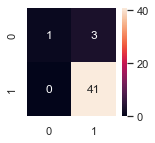

In [26]:
nmi = Cross_Validation(nmeans,'nmeans',df)

Test Set Accuracy = 0.8
 F1 Score = 0.7391304347826085

Confusion Matrix


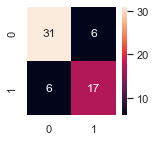

In [27]:
low_epoch(nmi,nmeans,'nmeans',df,Xt,yt)

## Bayes

Epoch 0 error is = 0.34782608695652173
Epoch 1 error is = 0.15217391304347827
Epoch 2 error is = 0.17391304347826086
Epoch 3 error is = 0.0444444444444444

Lowest error is at Epoch 3 with 0.0444444444444444
Best Validation Set Accuracy = 0.9555555555555556
 F1 Score = 0.9761904761904763

Confusion Matrix


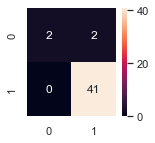

In [28]:
bi = Cross_Validation(Bayes,'Bayes',df)

Test Set Accuracy = 0.8666666666666667
 F1 Score = 0.84

Confusion Matrix


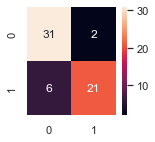

In [29]:
low_epoch(bi,Bayes,'Bayes',df,Xt,yt)

## Perceptron

The lowest error pair is (0.01, 1000) with Erms 0.6946477651148641
Epoch 0 error is = 0.26086956521739135
The lowest error pair is (0.01, 1000) with Erms 0.9058096501891952
Epoch 1 error is = 0.21739130434782605
The lowest error pair is (0.01, 1000) with Erms 0.4067422804974323
Epoch 2 error is = 0.06521739130434778
The lowest error pair is (0.01, 100) with Erms 0.4515519969087185
Epoch 3 error is = 0.06666666666666665

Lowest error is at Epoch 2 with 0.06521739130434778
Best Validation Set Accuracy = 0.9333333333333333
 F1 Score = 0.963855421686747

Confusion Matrix


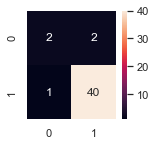

In [30]:
pi = Cross_Validation(Perceptron,'Perceptron',df)

Accuracy keeps varying best I got 83.33%

The lowest error pair is (0.01, 100) with Erms 0.5564158614744201
Test Set Accuracy = 0.8166666666666667
 F1 Score = 0.7441860465116279

Confusion Matrix


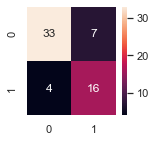

In [31]:
low_epoch(pi,Perceptron,'Perceptron',df,Xt,yt)

## MSE

Epoch 0 error is = 0.23913043478260865
Epoch 1 error is = 0.19565217391304346
Epoch 2 error is = 0.13043478260869568
Epoch 3 error is = 0.06666666666666665

Lowest error is at Epoch 3 with 0.06666666666666665
Best Validation Set Accuracy = 0.9333333333333333
 F1 Score = 0.9647058823529412

Confusion Matrix


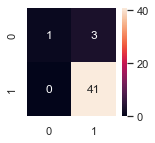

In [32]:
msei = Cross_Validation(MSE,'MSE',df)

Accuracy keeps varying best I got 83.33%

Test Set Accuracy = 0.85
 F1 Score = 0.7906976744186046

Confusion Matrix


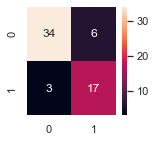

In [33]:
low_epoch(msei,MSE,'MSE',df,Xt,yt)

## SVM Linear

Epoch 0 error is = 0.4565217391304348
Epoch 1 error is = 0.32608695652173914
Epoch 2 error is = 0.6739130434782609
Epoch 3 error is = 0.1333333333333333

Lowest error is at Epoch 3 with 0.1333333333333333
Best Validation Set Accuracy = 0.8666666666666667
 F1 Score = 0.923076923076923

Confusion Matrix


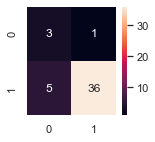

In [34]:
sli = Cross_Validation(SVM_linear,'SVM_linear',df)

Test Set Accuracy = 0.5166666666666667
 F1 Score = 0.5797101449275363

Confusion Matrix


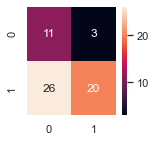

In [35]:
low_epoch(sli,SVM_linear,'SVM_linear',df,Xt,yt)

## SVM RBF

Epoch 0 error is = 0.10869565217391308
Epoch 1 error is = 0.23913043478260865
Epoch 2 error is = 0.19565217391304346
Epoch 3 error is = 0.06666666666666665

Lowest error is at Epoch 3 with 0.06666666666666665
Best Validation Set Accuracy = 0.9333333333333333
 F1 Score = 0.9647058823529412

Confusion Matrix


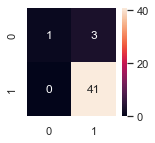

In [36]:
sbi = Cross_Validation(SVM_RBF,'SVM_RBF',df)

Test Set Accuracy = 0.8
 F1 Score = 0.76

Confusion Matrix


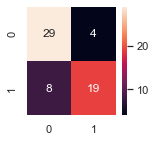

In [37]:
low_epoch(sbi,SVM_RBF,'SVM_RBF',df,Xt,yt)

# Testing the metrics on Test set with entire Train (no split)

## Trivial

Test Set Accuracy = 0.5
 F1 Score = 0.5161290322580646

Confusion Matrix


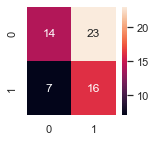

In [38]:
yhtri = trivial(len(Xt),df)
scores(yt,yhtri,'Test Set')

## N Means

Test Set Accuracy = 0.7833333333333333
 F1 Score = 0.6285714285714286

Confusion Matrix


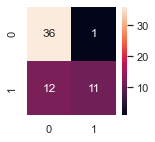

In [39]:
yhnmean = nmeans(X,y,Xt)
scores(yt,yhnmean,'Test Set')

## Bayes

Test Set Accuracy = 0.8666666666666667
 F1 Score = 0.8461538461538461

Confusion Matrix


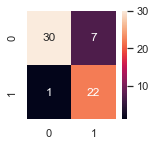

In [40]:
yhb = Bayes(df,X,y,Xt)
scores(yt,yhb,'Test Set')

## Perceptron

As we are randomly suffelling for Sequential GD the accuracy will vary, the best was 85% on base dataset

In [41]:
yhperc = Perceptron(dfs[:,1:],Xt)

The lowest error pair is (0.01, 1000) with Erms 0.7417432701726769


Test Set Accuracy = 0.8166666666666667
 F1 Score = 0.7555555555555555

Confusion Matrix


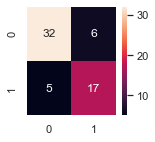

In [42]:
scores(yhperc,yt,'Test Set')

## MSE

As I am using sequentaial GD the randomnes varies the accuracy, highest i achieved was 86.66%

In [43]:
yhmse = MSE(dfs[:,1:],Xt)

Test Set Accuracy = 0.8333333333333334
 F1 Score = 0.7916666666666667

Confusion Matrix


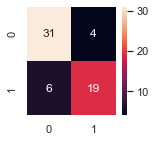

In [44]:
scores(yhmse,yt,'Test Set')

## SVM Linear

Test Set Accuracy = 0.7833333333333333
 F1 Score = 0.6666666666666667

Confusion Matrix


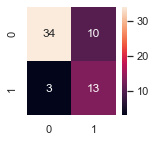

In [45]:
z = get_z(y)
yh2 = SVM_linear(X,z,None,Xt)
scores(yh2,yt,'Test Set')

## SVM RBF

### Iterating through gamma values from 0.001 to 0.2, to find gamma with highest accuracy

In [ ]:
acc = []
for i in np.arange(0.001,0.2,0.002):
    yh = SVM_RBF(X,get_z(y),i,Xt)
    acc.append(accuracy(yt,yh))

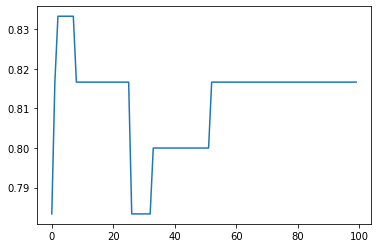

In [364]:
plt.plot(acc)

Optimal weight was around 0.01 giving 83.333% accuracy

Test Set Accuracy = 0.8333333333333334
 F1 Score = 0.8076923076923076

Confusion Matrix


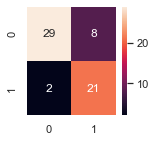

In [47]:
yh = SVM_RBF(X,z,0.01,Xt)
scores(yt,yh,'Test Set')

# Feature Expansion

Let's augment the feature space by modifying some existing features and later do feature selection

In [48]:
dfex = pd.read_csv('algerian_fires_train.csv')
dfex.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,01/06/2012,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,6.225461,0
1,01/06/2012,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,2.268104,0
2,02/06/2012,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,-3.327908,0
3,02/06/2012,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,0.131303,0
4,03/06/2012,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,-1.928471,0


## Change date from str to date time format

In [49]:
dfex['Date']=pd.to_datetime(dfex['Date'],dayfirst=True)

## Augmenting Features

I am going to take the Average, Max, Min, Median and Standard deviation of Temperature,Humidity,Wind Speed and Rain over the past 7 days, 5 days and 2 days and add them to dataset. So in total including date column, **D' = 10+(3.4.4) = 58 features**.

The basic thumb rule is **N > (3 - 10 ) * D+1**. So according to this as N = 184, the range for D is from **17 - 61** features. D' = 58 features falls in this range so we can train the entire expanded feature set. But we will later do feature selection.

In [50]:
def fea_exp(dfex):
    for j in [7,5,2]:

        dfex[f'Avg Temperature - {j}'] = np.zeros(len(dfex))
        dfex[f'Avg RH - {j}'] = np.zeros(len(dfex))
        dfex[f'Avg Ws - {j}'] = np.zeros(len(dfex))
        dfex[f'Avg Rain - {j}'] = np.zeros(len(dfex))

        dfex[f'Max Temperature - {j}'] = np.zeros(len(dfex))
        dfex[f'Max RH - {j}'] = np.zeros(len(dfex))
        dfex[f'Max Ws - {j}'] = np.zeros(len(dfex))
        dfex[f'Max Rain - {j}'] = np.zeros(len(dfex))

        dfex[f'Min Temperature - {j}'] = np.zeros(len(dfex))
        dfex[f'Min RH - {j}'] = np.zeros(len(dfex))
        dfex[f'Min Ws - {j}'] = np.zeros(len(dfex))
        dfex[f'Min Rain - {j}'] = np.zeros(len(dfex))

        dfex[f'Median Temperature - {j}'] = np.zeros(len(dfex))
        dfex[f'Median RH - {j}'] = np.zeros(len(dfex))
        dfex[f'Median Ws - {j}'] = np.zeros(len(dfex))
        dfex[f'Median Rain - {j}'] = np.zeros(len(dfex))

        for i in range(len(dfex)):

            data = dfex[(dfex['Date']>=dfex['Date'][i]-pd.Timedelta(days=j)) & (dfex['Date']<dfex['Date'][i])]
            dfex[f'Avg Temperature - {j}'][i] = data['Temperature'].mean()
            dfex[f'Avg RH - {j}'][i] = data['RH'].mean()
            dfex[f'Avg Ws - {j}'][i] = data['Ws'].mean()
            dfex[f'Avg Rain - {j}'][i] = data['Rain'].mean()

            dfex[f'Max Temperature - {j}'][i] = data['Temperature'].max()
            dfex[f'Max RH - {j}'][i] = data['RH'].max()
            dfex[f'Max Ws - {j}'][i] = data['Ws'].max()
            dfex[f'Max Rain - {j}'][i] = data['Rain'].max()

            dfex[f'Min Temperature - {j}'][i] = data['Temperature'].min()
            dfex[f'Min RH - {j}'][i] = data['RH'].min()
            dfex[f'Min Ws - {j}'][i] = data['Ws'].min()
            dfex[f'Min Rain - {j}'][i] = data['Rain'].min()

            dfex[f'Median Temperature - {j}'][i] = data['Temperature'].median()
            dfex[f'Median RH - {j}'][i] = data['RH'].median()
            dfex[f'Median Ws - {j}'][i] = data['Ws'].median()
            dfex[f'Median Rain - {j}'][i] = data['Rain'].median()  
    return dfex

In [51]:
dfex = fea_exp(dfex)

## Replacing Nan values for the starting values with the mean of that column

In [52]:
dfex.iloc[:,8:13].head()

,ISI,BUI,Classes,Avg Temperature - 7,Avg RH - 7
0,0.487246,6.225461,0,NaN,NaN
1,-1.472158,2.268104,0,NaN,NaN
2,1.338737,-3.327908,0,26.725504,45.043153
3,-0.755090,0.131303,0,26.725504,45.043153
4,0.558249,-1.928471,0,23.389402,61.770146


In [53]:
for i in dfex.columns[11:]:
    for j in range(2):
        dfex[i][j] = dfex[i].mean()

In [54]:
dfex.iloc[:,8:13].head()

,ISI,BUI,Classes,Avg Temperature - 7,Avg RH - 7
0,0.487246,6.225461,0,32.773747,60.305950
1,-1.472158,2.268104,0,32.773747,60.305950
2,1.338737,-3.327908,0,26.725504,45.043153
3,-0.755090,0.131303,0,26.725504,45.043153
4,0.558249,-1.928471,0,23.389402,61.770146


## ** Removing the last 7 days from train set as it will contain data in the test set **

As 7 days is the maximum we are considering

In [55]:
dfex.tail()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,...,Max Ws - 2,Max Rain - 2,Min Temperature - 2,Min RH - 2,Min Ws - 2,Min Rain - 2,Median Temperature - 2,Median RH - 2,Median Ws - 2,Median Rain - 2
179,2012-08-29,28.449213,57.127011,15.195444,-0.161958,71.450733,57.128627,239.290670,11.267031,68.680725,...,25.236657,0.441210,25.427053,33.537444,7.323591,-0.052653,32.267581,50.071274,14.046092,0.302474
180,2012-08-30,26.680911,73.619431,17.054505,0.127765,61.231373,18.986399,170.968390,9.496533,39.281865,...,18.919395,0.704918,25.427053,33.537444,9.172789,-0.161958,32.908271,49.187007,14.028106,0.194279
181,2012-08-30,44.750966,58.428753,21.687939,0.995222,62.921683,27.594857,176.118476,-0.271474,30.340267,...,18.919395,0.704918,25.427053,33.537444,9.172789,-0.161958,32.908271,49.187007,14.028106,0.194279
182,2012-08-31,33.298270,79.558329,20.464269,17.019373,47.242905,6.039570,-11.298033,0.035798,4.744741,...,21.687939,0.995222,26.680911,42.920337,12.860767,-0.161958,32.908271,57.777882,16.124974,0.416342
183,2012-08-31,32.762295,84.322685,21.653932,-0.213253,67.294270,33.599199,165.945211,10.440299,35.986552,...,21.687939,0.995222,26.680911,42.920337,12.860767,-0.161958,32.908271,57.777882,16.124974,0.416342


In [56]:
dfex = dfex[dfex['Date']<(dfex['Date'][len(dfex)-1]-pd.Timedelta(days=7))]

Checking if the last 7 days are removed

In [57]:
dfex.tail()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,...,Max Ws - 2,Max Rain - 2,Min Temperature - 2,Min RH - 2,Min Ws - 2,Min Rain - 2,Median Temperature - 2,Median RH - 2,Median Ws - 2,Median Rain - 2
163,2012-08-21,38.974406,38.708515,21.078248,-0.196080,114.270824,28.324008,156.279593,9.850906,36.338345,...,25.719072,0.216639,29.276266,37.988082,16.775674,-0.278088,36.558474,46.510156,20.237203,0.184716
164,2012-08-22,30.896242,48.836994,20.114324,0.278984,91.425389,37.232181,114.531143,6.745771,41.499593,...,25.719072,0.164612,22.306773,38.708515,16.775674,-0.278088,34.794234,53.520168,18.980650,-0.044174
165,2012-08-22,39.904877,62.449343,11.446256,0.033836,91.196227,34.722303,142.729175,9.831573,39.743423,...,25.719072,0.164612,22.306773,38.708515,16.775674,-0.278088,34.794234,53.520168,18.980650,-0.044174
166,2012-08-23,48.038777,63.133020,16.675465,-0.333441,104.399432,48.922137,144.539130,9.747095,53.349689,...,21.078248,0.278984,22.306773,38.708515,11.446256,-0.196080,34.935324,55.643169,18.498688,0.070785
167,2012-08-23,39.287463,54.760134,18.612077,0.320175,86.555473,33.090678,144.795556,8.520974,43.813670,...,21.078248,0.278984,22.306773,38.708515,11.446256,-0.196080,34.935324,55.643169,18.498688,0.070785


## Entire process is repeated for the test set

In [58]:
dfext = pd.read_csv('algerian_fires_test.csv')
dfext['Date']=pd.to_datetime(dfext['Date'],dayfirst=True)
dfext.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,2012-09-01,15.861392,103.083493,23.929982,6.862311,18.206803,6.705575,16.934059,1.272175,1.567136,0
1,2012-09-01,25.127811,85.095686,16.066414,-0.332408,36.300922,4.307622,-8.813586,-1.707135,-2.167708,0
2,2012-09-02,25.804539,112.848312,8.603607,10.148430,32.909853,-3.989974,12.276834,0.886849,5.108220,0
3,2012-09-02,39.157179,40.359214,13.347197,-0.050950,101.833950,4.923229,17.509484,1.000106,1.990220,0
4,2012-09-03,14.943534,51.887200,14.976143,3.910505,66.608357,0.628217,17.332474,-1.773158,9.083053,0


In [59]:
dfext = fea_exp(dfext)

In [60]:
dfext.iloc[:,8:13].head()

,ISI,BUI,Classes,Avg Temperature - 7,Avg RH - 7
0,1.272175,1.567136,0,NaN,NaN
1,-1.707135,-2.167708,0,NaN,NaN
2,0.886849,5.108220,0,20.494601,94.089590
3,1.000106,1.990220,0,20.494601,94.089590
4,-1.773158,9.083053,0,26.487730,85.346677


In [61]:
for i in dfext.columns[11:]:
    for j in range(2):
        dfext[i][j] = dfext[i].mean()

In [62]:
dfext.head()

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,...,Max Ws - 2,Max Rain - 2,Min Temperature - 2,Min RH - 2,Min Ws - 2,Min Rain - 2,Median Temperature - 2,Median RH - 2,Median Ws - 2,Median Rain - 2
0,2012-09-01,15.861392,103.083493,23.929982,6.862311,18.206803,6.705575,16.934059,1.272175,1.567136,...,21.621763,3.600236,20.095227,46.306863,10.720009,-0.131692,31.296135,64.904185,15.745523,0.751244
1,2012-09-01,25.127811,85.095686,16.066414,-0.332408,36.300922,4.307622,-8.813586,-1.707135,-2.167708,...,21.621763,3.600236,20.095227,46.306863,10.720009,-0.131692,31.296135,64.904185,15.745523,0.751244
2,2012-09-02,25.804539,112.848312,8.603607,10.148430,32.909853,-3.989974,12.276834,0.886849,5.108220,...,23.929982,6.862311,15.861392,85.095686,16.066414,-0.332408,20.494601,94.089590,19.998198,3.264951
3,2012-09-02,39.157179,40.359214,13.347197,-0.050950,101.833950,4.923229,17.509484,1.000106,1.990220,...,23.929982,6.862311,15.861392,85.095686,16.066414,-0.332408,20.494601,94.089590,19.998198,3.264951
4,2012-09-03,14.943534,51.887200,14.976143,3.910505,66.608357,0.628217,17.332474,-1.773158,9.083053,...,23.929982,10.148430,15.861392,40.359214,8.603607,-0.332408,25.466175,94.089590,14.706806,3.405680


## Manual Shifting the Classes feature to last column to ease operations later

In [63]:
print(dfex.columns)

Index(['Date', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI',
       'BUI', 'Classes', 'Avg Temperature - 7', 'Avg RH - 7', 'Avg Ws - 7',
       'Avg Rain - 7', 'Max Temperature - 7', 'Max RH - 7', 'Max Ws - 7',
       'Max Rain - 7', 'Min Temperature - 7', 'Min RH - 7', 'Min Ws - 7',
       'Min Rain - 7', 'Median Temperature - 7', 'Median RH - 7',
       'Median Ws - 7', 'Median Rain - 7', 'Avg Temperature - 5', 'Avg RH - 5',
       'Avg Ws - 5', 'Avg Rain - 5', 'Max Temperature - 5', 'Max RH - 5',
       'Max Ws - 5', 'Max Rain - 5', 'Min Temperature - 5', 'Min RH - 5',
       'Min Ws - 5', 'Min Rain - 5', 'Median Temperature - 5', 'Median RH - 5',
       'Median Ws - 5', 'Median Rain - 5', 'Avg Temperature - 2', 'Avg RH - 2',
       'Avg Ws - 2', 'Avg Rain - 2', 'Max Temperature - 2', 'Max RH - 2',
       'Max Ws - 2', 'Max Rain - 2', 'Min Temperature - 2', 'Min RH - 2',
       'Min Ws - 2', 'Min Rain - 2', 'Median Temperature - 2', 'Median RH - 2',
       'Median W

In [64]:
cm = ['Date', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI',
       'BUI', 'Avg Temperature - 7', 'Avg RH - 7', 'Avg Ws - 7',
       'Avg Rain - 7', 'Max Temperature - 7', 'Max RH - 7', 'Max Ws - 7',
       'Max Rain - 7', 'Min Temperature - 7', 'Min RH - 7', 'Min Ws - 7',
       'Min Rain - 7', 'Median Temperature - 7', 'Median RH - 7',
       'Median Ws - 7', 'Median Rain - 7', 'Avg Temperature - 5', 'Avg RH - 5',
       'Avg Ws - 5', 'Avg Rain - 5', 'Max Temperature - 5', 'Max RH - 5',
       'Max Ws - 5', 'Max Rain - 5', 'Min Temperature - 5', 'Min RH - 5',
       'Min Ws - 5', 'Min Rain - 5', 'Median Temperature - 5', 'Median RH - 5',
       'Median Ws - 5', 'Median Rain - 5', 'Avg Temperature - 2', 'Avg RH - 2',
       'Avg Ws - 2', 'Avg Rain - 2', 'Max Temperature - 2', 'Max RH - 2',
       'Max Ws - 2', 'Max Rain - 2', 'Min Temperature - 2', 'Min RH - 2',
       'Min Ws - 2', 'Min Rain - 2', 'Median Temperature - 2', 'Median RH - 2',
       'Median Ws - 2', 'Median Rain - 2', 'Classes']
dfex = dfex[cm]
dfext = dfext[cm]

# Cross Validation on Expanded Dataset

After expanding the dataset, we have to make sure the last x days of the validation set is removed if followed by train set and vice versa. So the function is modified to accomodate this.

In [65]:
def Cross_Validation_expand(model,name,df):
    error = {}
    for i in range(4):

        
        if i == 0:
            p = 0
        else:
            p = df[df['Date']==(df['Date'].iloc[46*(i)]-pd.Timedelta(days=7))].index.values[0]
            
        if i == 3:
            q = -1
        else:
            q = 46*(i+1)
        
        dftran = df[(df['Date']>=df['Date'].iloc[46*(i)]) & (df['Date']<(df['Date'].iloc[q]-pd.Timedelta(days=7)))]
        Xval = dftran.iloc[:,1:-1].values
        yval = dftran.iloc[:,-1].values
        dfs = df.drop(df.index[p:q]).iloc[:,1:].values
        Xtr = df.drop(df.index[p:q]).iloc[:,1:-1].values
        ytr = df.drop(df.index[p:q]).iloc[:,-1].values
        ztr = get_z(ytr)
        
        if name == 'SVM_linear' or name == 'SVM_RBF':
            yh = model(Xtr,ztr,0.01,Xval)

        elif name == 'nmeans':
            yh = model(Xtr,ytr,Xval)

        elif name == 'Perceptron' or name == 'MSE':
            yh = model(dfs,Xval)

        elif name == 'Bayes':
                yh = model(df,Xtr,ytr,Xval)


        else:
            print('Enter Valid Model')

        error[i] = 1-accuracy(yval,yh)

        print(f'Epoch {i} error is = {1-accuracy(yval,yh)}')
    m = min(error, key=error.get)
    print(f'\nLowest error is at Epoch {m} with {error[m]}')
    
    scores(yh,yval,'Best Validation Set')
    
    
    return m

In [66]:
def low_epoch_expand(i,model,name,df,Xt,yt):
    if i == 0:
        p = 0
    else:
        p = df[df['Date']==(df['Date'].iloc[46*(i)]-pd.Timedelta(days=7))].index.values[0]
        
    if i == 3:
        q = -1
    else:
        q = 46*(i+1)
        
    dfs = df.drop(df.index[p:q]).iloc[:,1:].values        
    Xtr = df.drop(df.index[p:q]).iloc[:,1:-1].values
    ytr = df.drop(df.index[p:q]).iloc[:,-1].values
    ztr = get_z(ytr)
    
    if name == 'SVM_linear' or name == 'SVM_RBF':
        yh = model(Xtr,ztr,0.007,Xt)

    elif name == 'nmeans':
        yh = model(Xtr,ytr,Xt)

    elif name == 'Perceptron' or name == 'MSE':
        yh = model(dfs,Xt)

    elif name == 'Bayes':
            yh = model(df,Xtr,ytr,Xt)


    else:
        print('Enter Valid Model')
        
    scores(yh,yt,'Test Set')

In [67]:
dfsn = dfex.iloc[:,1:].values
Xn = dfex.iloc[:,1:-1].values
yn = dfex.iloc[:,-1].values
zn = get_z(yn)
Xtn = dfext.iloc[:,1:-1].values
ytn = dfext.iloc[:,-1].values

### N means

Epoch 0 error is = 0.1875
Epoch 1 error is = 0.3125
Epoch 2 error is = 0.25
Epoch 3 error is = 0.0714285714285714

Lowest error is at Epoch 3 with 0.0714285714285714
Best Validation Set Accuracy = 0.9285714285714286
 F1 Score = 0.962962962962963

Confusion Matrix


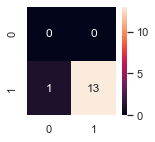

In [68]:
nmi = Cross_Validation_expand(nmeans,'nmeans',dfex)

Test Set Accuracy = 0.8166666666666667
 F1 Score = 0.7441860465116279

Confusion Matrix


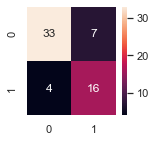

In [69]:
low_epoch_expand(nmi,nmeans,'nmeans',dfex,Xtn,ytn)

### SVM Linear

Epoch 0 error is = 0.40625
Epoch 1 error is = 0.46875
Epoch 2 error is = 0.59375
Epoch 3 error is = 0.3571428571428571

Lowest error is at Epoch 3 with 0.3571428571428571
Best Validation Set Accuracy = 0.6428571428571429
 F1 Score = 0.7826086956521738

Confusion Matrix


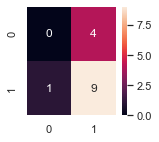

In [70]:
sli = Cross_Validation_expand(SVM_linear,'SVM_linear',dfex)

Test Set Accuracy = 0.7166666666666667
 F1 Score = 0.5853658536585366

Confusion Matrix


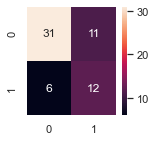

In [71]:
low_epoch_expand(sli,SVM_linear,'SVM_linear',dfex,Xtn,ytn)

### SVM RBF

Epoch 0 error is = 0.125
Epoch 1 error is = 0.28125
Epoch 2 error is = 0.15625
Epoch 3 error is = 0.0714285714285714

Lowest error is at Epoch 3 with 0.0714285714285714
Best Validation Set Accuracy = 0.9285714285714286
 F1 Score = 0.962962962962963

Confusion Matrix


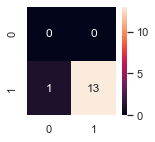

In [72]:
sbi = Cross_Validation_expand(SVM_RBF,'SVM_RBF',dfex)

Test Set Accuracy = 0.8333333333333334
 F1 Score = 0.7999999999999999

Confusion Matrix


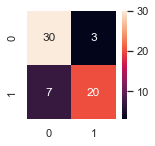

In [73]:
low_epoch_expand(sbi,SVM_RBF,'SVM_RBF',dfex,Xtn,ytn)

### Perceptron

The lowest error pair is (0.01, 1000) with Erms 1.303973916663879
Epoch 0 error is = 0.21875
The lowest error pair is (0.01, 1000) with Erms 1.4090771633431005
Epoch 1 error is = 0.15625
The lowest error pair is (0.01, 1000) with Erms 0.9355581253658861
Epoch 2 error is = 0.25
The lowest error pair is (0.01, 1000) with Erms 1.6476756802063017
Epoch 3 error is = 0.1428571428571429

Lowest error is at Epoch 3 with 0.1428571428571429
Best Validation Set Accuracy = 0.8571428571428571
 F1 Score = 0.9166666666666666

Confusion Matrix


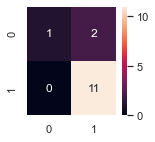

In [74]:
pi = Cross_Validation_expand(Perceptron,'Perceptron',dfex)

The lowest error pair is (0.01, 1000) with Erms 1.7171637819786887
Test Set Accuracy = 0.8
 F1 Score = 0.7499999999999999

Confusion Matrix


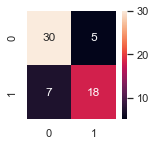

In [78]:
low_epoch_expand(pi,Perceptron,'Perceptron',dfex,Xtn,ytn)

### MSE

Epoch 0 error is = 0.53125
Epoch 1 error is = 0.4375
Epoch 2 error is = 0.28125
Epoch 3 error is = 0.7857142857142857

Lowest error is at Epoch 2 with 0.28125
Best Validation Set Accuracy = 0.21428571428571427
 F1 Score = 0.3529411764705882

Confusion Matrix


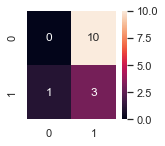

In [76]:
msei = Cross_Validation_expand(MSE,'MSE',dfex)

Test Set Accuracy = 0.48333333333333334
 F1 Score = 0.45614035087719296

Confusion Matrix


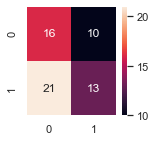

In [81]:
low_epoch_expand(msei,MSE,'MSE',dfex,Xtn,ytn)

### Bayes

Wasn't able to perform cross validation as E was too small while taking inverse and math domain error was caused

# Checking Metrics on new complete expanded train set (no split)

In [82]:
dfsn = dfex.iloc[:,1:].values
Xn = dfex.iloc[:,1:-1].values
yn = dfex.iloc[:,-1].values
zn = get_z(yn)
Xtn = dfext.iloc[:,1:-1].values
ytn = dfext.iloc[:,-1].values

## Trivial

Test Set Accuracy = 0.5166666666666667
 F1 Score = 0.5084745762711865

Confusion Matrix


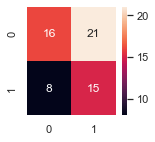

In [83]:
yhtri = trivial(len(Xtn),dfex)
scores(ytn,yhtri,'Test Set')

### N means

Test Set Accuracy = 0.8
 F1 Score = 0.6842105263157895

Confusion Matrix


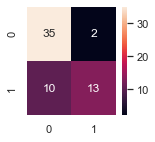

In [84]:
yhnme = nmeans(Xn,yn,Xtn)
scores(ytn,yhnme,'Test Set')

### SVM Linear

Test Set Accuracy = 0.45
 F1 Score = 0.2978723404255319

Confusion Matrix


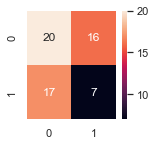

In [85]:
yhsvml = SVM_linear(Xn,zn,None,Xtn)
scores(yhsvml,ytn,'Test Set')

### SVM RBF

Test Set Accuracy = 0.85
 F1 Score = 0.8235294117647057

Confusion Matrix


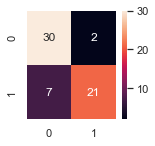

In [86]:
yhsvmr = SVM_RBF(Xn,zn,0.002,Xtn)
scores(yhsvmr,ytn,'Test Set')

### Perceptron

The lowest error pair is (0.01, 1000) with Erms 1.7280755995363988
Test Set Accuracy = 0.8
 F1 Score = 0.76

Confusion Matrix


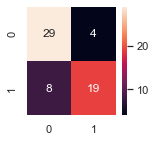

In [87]:
yhpc = Perceptron(dfsn,Xtn)
scores(yhpc,ytn,'Test Set')

### MSE

Test Set Accuracy = 0.5166666666666667
 F1 Score = 0.3829787234042554

Confusion Matrix


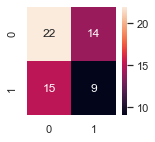

In [88]:
yhmse = MSE(dfsn,Xtn)
scores(yhmse,ytn,'Test Set')

### Bayes

Test Set Accuracy = 0.4166666666666667
 F1 Score = 0.5679012345679012

Confusion Matrix


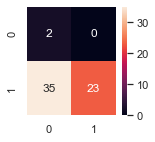

In [89]:
yhbay = Bayes(dfex,Xn,yn,Xtn)
scores(yhbay,ytn,'Test Set')

# Feature Selection

## Using Pearson correlation coefficient

Use pandas derive the correlation matrix and find the features with more than a desired value. I have considered 0.33 as it gave me the best accuracies for most models

In [90]:
def pcc_fea_sel(dfex,val):
    cols = []
    for i in range(len(dfex.columns)-1):
        if (abs(dfex.corr()['Classes'])>val)[i] == True:
            cols.append((dfex.corr()['Classes']).index[i])
    return cols

In [91]:
cols = pcc_fea_sel(dfex,0.33)

In [92]:
len(cols)

16

Cols has **16** features ewhich is almost in the **17 - 61** range which is the optimal range according to the thumb rule **N > (3-10)D+1**

In [93]:
dfn = dfex[cols]
dfnt = dfext[cols]

In [94]:
dfnt.head()

,Rain,FFMC,DMC,DC,ISI,BUI,Avg Temperature - 7,Max Temperature - 7,Median Temperature - 7,Avg Temperature - 5,Max Temperature - 5,Avg Rain - 2,Max Temperature - 2,Max Rain - 2,Median Rain - 2,Classes
0,6.862311,18.206803,6.705575,16.934059,1.272175,1.567136,30.546717,43.304756,31.114061,30.510891,42.144910,1.242758,39.466890,3.600236,0.751244,0
1,-0.332408,36.300922,4.307622,-8.813586,-1.707135,-2.167708,30.546717,43.304756,31.114061,30.510891,42.144910,1.242758,39.466890,3.600236,0.751244,0
2,10.148430,32.909853,-3.989974,12.276834,0.886849,5.108220,20.494601,25.127811,20.494601,20.494601,25.127811,3.264951,25.127811,6.862311,3.264951,0
3,-0.050950,101.833950,4.923229,17.509484,1.000106,1.990220,20.494601,25.127811,20.494601,20.494601,25.127811,3.264951,25.127811,6.862311,3.264951,0
4,3.910505,66.608357,0.628217,17.332474,-1.773158,9.083053,26.487730,39.157179,25.466175,26.487730,39.157179,4.156846,39.157179,10.148430,3.405680,0


## Checking Metrics on entire new selected features

In [95]:
dfsn = dfn.values
Xn = dfn.iloc[:,:-1].values
yn = dfn.iloc[:,-1].values
zn = get_z(yn)
Xtn = dfnt.iloc[:,:-1].values
ytn = dfnt.iloc[:,-1].values

### N means

Test Set Accuracy = 0.8333333333333334
 F1 Score = 0.75

Confusion Matrix


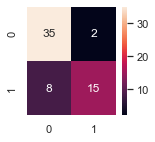

In [96]:
yhnme = nmeans(Xn,yn,Xtn)
scores(ytn,yhnme,'Test Set')

### SVM Linear

Test Set Accuracy = 0.23333333333333334
 F1 Score = 0.20689655172413796

Confusion Matrix


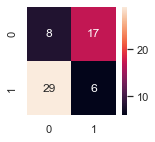

In [97]:
yhsvml = SVM_linear(Xn,zn,0.01,Xtn)
scores(yhsvml,ytn,'Test Set')

### SVM RBF

Test Set Accuracy = 0.7833333333333333
 F1 Score = 0.7636363636363634

Confusion Matrix


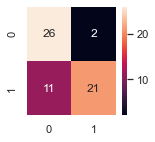

In [98]:
yhsvmr = SVM_RBF(Xn,zn,0.01,Xtn)
scores(yhsvmr,ytn,'Test Set')

### Perceptron

The accuracies varied due to the randomness, highest accuracy = 91%, F1 score = 0.888, while the pearson corelation is atleast 0.33 or more. It is to be noted this accuracy cannot be achieved every single time.

The lowest error pair is (0.01, 10) with Erms 0.19476245641577777
 Accuracy = 0.9166666666666666
 F1 Score = 0.888888888888889

Confusion Matrix


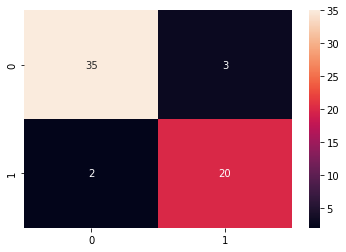

In [504]:
yhpc = Perceptron(dfsn,Xtn)
scores(yhpc,ytn,'Test Set')

Run the model for 50 iterations, to find how well it performs

In [714]:
accu = []
for i in range(50):
    yhpc = Perceptron(dfsn,Xtn)
    accu.append(accuracy(yhpc,ytn))


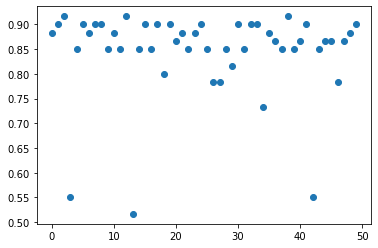

In [715]:
plt.scatter(list(range(50)),accu)

As we can see most of the times the accuracy is close to 90%, hence we can use this model to recieve an accuracy for around 88-90 %

### MSE

The accuracies varied due to the randomness, highest accuracy = 95%, F1 score = 0.92, while the pearson corelation is atleast 0.33 or more. It is to be noted this accuracy cannot be achieved every single time.

Test Set Accuracy = 0.9166666666666666
 F1 Score = 0.888888888888889

Confusion Matrix


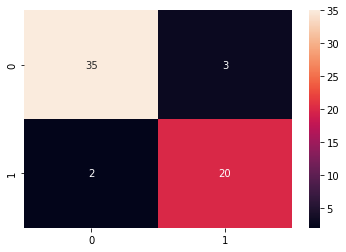

In [815]:
yhmse = MSE(dfsn,Xtn)
scores(yhmse,ytn,'Test Set')

Run the model for 50 iterations, to find how well it performs

In [781]:
accu2 = []
for i in range(50):
    yhmse = MSE(dfsn,Xtn)
    accu2.append(accuracy(yhmse,ytn))


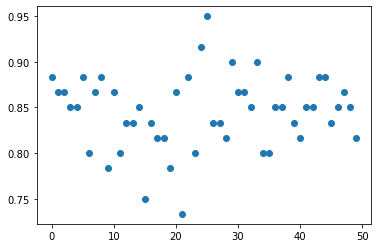

In [782]:
plt.scatter(list(range(50)),accu2)

Even though this model was able to achieve the highest accuracy that is 95%, this model is not reliable as the spread or the randomness affects it very much and avg accuracy is around 85%.

### Bayes

Test Set Accuracy = 0.75
 F1 Score = 0.6666666666666666

Confusion Matrix


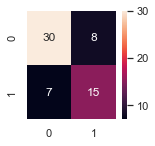

In [99]:
yhbay = Bayes(dfn,Xn,yn,Xtn)
scores(yhbay,ytn,'Test Set')

## Based on Individual features accuracy based on model

I predicted the output using every single features on all the model and choose the features with arounf 65% accuracy or more

In [105]:
def fet_sel_acc(df,df_t,model,name,desired_acc):
    feat = []
    for i in df.columns:
        if i == 'Date' or i == 'Classes':
            continue
        cols = [i,'Classes']
        dfn = df[cols]
        dfnt = df_t[cols]
        dfsn = dfn.values
        Xn = dfn.iloc[:,:-1].values
        yn = dfn.iloc[:,-1].values
        zn = get_z(yn)
        Xtn = dfnt.iloc[:,:-1].values
        ytn = dfnt.iloc[:,-1].values

        
        try:
            if name == 'SVM_linear' or name == 'SVM_RBF':
                yh = model(Xn,zn,0.01,Xtn)
                
            elif name == 'nmeans':
                yh = model(Xn,yn,Xtn)
                
            elif name == 'Perceptron' or name == 'MSE':
                yh = model(dfsn,Xtn)
                
            elif name == 'Bayes':
                yh = model(dfn,Xn,yn,Xtn)
                
            else:
                print('Enter Valid Model')
                
        except:
            pass
        
        acc = accuracy(yh,ytn)
        #print(f'{i} = {accuracy(yh,ytn)}')
        if acc > desired_acc:
            feat.append(i)
    feat.append('Classes')
    return feat

In [106]:
def acc_feat_sel(feat,df,df_t,model,name):
    dfn = df[feat]
    dfnt = df_t[feat]
    dfsn = dfn.values
    Xn = dfn.iloc[:,:-1].values
    yn = dfn.iloc[:,-1].values
    zn = get_z(yn)
    Xtn = dfnt.iloc[:,:-1].values
    ytn = dfnt.iloc[:,-1].values
    
    if name == 'SVM_linear' or name == 'SVM_RBF':
        yh = model(Xn,zn,0.01,Xtn)

    elif name == 'nmeans':
        yh = model(Xn,yn,Xtn)

    elif name == 'Perceptron' or name == 'MSE':
        yh = model(dfsn,Xtn)

    elif name == 'Bayes':
        yh = model(dfn,Xn,yn,Xtn)

    else:
        print('Enter Valid Model')
    scores(yh,ytn,'Test Set')

### N means

In [104]:
feat = fet_sel_acc(dfex,dfext,nmeans,'nmeans',0.65)

Temperature = 0.65
RH = 0.6
Ws = 0.5166666666666667
Rain = 0.6833333333333333
FFMC = 0.6666666666666666
DMC = 0.7666666666666667
DC = 0.8
ISI = 0.8833333333333333
BUI = 0.7333333333333333
Avg Temperature - 7 = 0.6166666666666667
Avg RH - 7 = 0.6166666666666667
Avg Ws - 7 = 0.5166666666666667
Avg Rain - 7 = 0.55
Max Temperature - 7 = 0.55
Max RH - 7 = 0.65
Max Ws - 7 = 0.5166666666666667
Max Rain - 7 = 0.55
Min Temperature - 7 = 0.6166666666666667
Min RH - 7 = 0.5833333333333334
Min Ws - 7 = 0.6166666666666667
Min Rain - 7 = 0.55
Median Temperature - 7 = 0.65
Median RH - 7 = 0.5166666666666667
Median Ws - 7 = 0.55
Median Rain - 7 = 0.5833333333333334
Avg Temperature - 5 = 0.65
Avg RH - 5 = 0.65
Avg Ws - 5 = 0.5166666666666667
Avg Rain - 5 = 0.5833333333333334
Max Temperature - 5 = 0.6166666666666667
Max RH - 5 = 0.7166666666666667
Max Ws - 5 = 0.45
Max Rain - 5 = 0.5833333333333334
Min Temperature - 5 = 0.6166666666666667
Min RH - 5 = 0.6166666666666667
Min Ws - 5 = 0.48333333333333334


Test Set Accuracy = 0.8333333333333334
 F1 Score = 0.75

Confusion Matrix


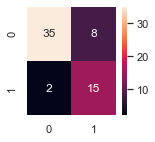

In [107]:
acc_feat_sel(feat,dfex,dfext,nmeans,'nmeans')

### MSE

In [108]:
feat = fet_sel_acc(dfex,dfext,MSE,'MSE',0.7)

Test Set Accuracy = 0.6166666666666667
 F1 Score = 0.0

Confusion Matrix


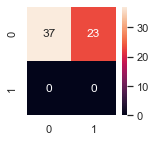

In [109]:
acc_feat_sel(feat,dfex,dfext,MSE,'MSE')

### Bayes

This is most reliable and best model among the others, with accuracy 88.33% and F1-score of 0.844, it is a bit lower than the perceptron model with pearsons feature selection but is more reliable.

In [835]:
feat = fet_sel_acc(dfex,dfext,Bayes,'Bayes',0.65)

Test Set Accuracy = 0.8833333333333333
 F1 Score = 0.8444444444444444

Confusion Matrix


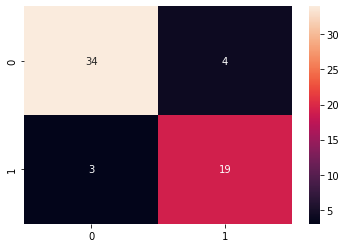

In [836]:
acc_feat_sel(feat,dfex,dfext,Bayes,'Bayes')

### SVM Linear

In [110]:
feat = fet_sel_acc(dfex,dfext,SVM_linear,'SVM_linear',0.71)

Test Set Accuracy = 0.5
 F1 Score = 0.39999999999999997

Confusion Matrix


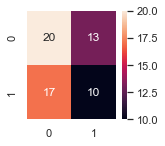

In [111]:
acc_feat_sel(feat,dfex,dfext,SVM_linear,'SVM_linear')

### SVM RBF

In [112]:
feat = fet_sel_acc(dfex,dfext,SVM_RBF,'SVM_RBF',0.71)

Test Set Accuracy = 0.7833333333333333
 F1 Score = 0.711111111111111

Confusion Matrix


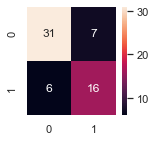

In [113]:
acc_feat_sel(feat,dfex,dfext,SVM_RBF,'SVM_RBF')

### Perceptron

In [117]:
feat = fet_sel_acc(dfex,dfext,Perceptron,'Perceptron',0.65)

Test Set Accuracy = 0.8333333333333334
 F1 Score = 0.7727272727272727

Confusion Matrix


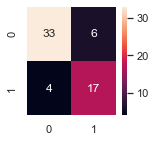

In [118]:
acc_feat_sel(feat,dfex,dfext,Perceptron,'Perceptron')

# Performing Normalization and Standardization on best models after feature selection to see if there is improvement or deterioration

## Normalization

In [119]:
ndf = dfex[:]
for i in dfex.columns:
    if i == 'Date' or i == 'Classes':
        continue
    ndf[i] = (ndf[i]-ndf[i].min())/(ndf[i].max()-ndf[i].min())

In [120]:
ndft = dfext[:]
for i in dfext.columns:
    if i == 'Date' or i == 'Classes':
        continue
    ndft[i] = (ndft[i]-ndft[i].min())/(ndft[i].max()-ndft[i].min())

### N means Accuracy feature selection

In [121]:
feat = fet_sel_acc(ndf,ndft,nmeans,'nmeans',0.65)

Test Set Accuracy = 0.8166666666666667
 F1 Score = 0.7555555555555555

Confusion Matrix


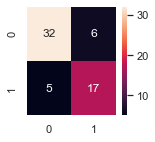

In [122]:
acc_feat_sel(feat,ndf,ndft,nmeans,'nmeans')

### Bayes Accuracy feature selection

In [123]:
feat = fet_sel_acc(ndf,ndft,Bayes,'Bayes',0.65)

Test Set Accuracy = 0.8
 F1 Score = 0.7777777777777777

Confusion Matrix


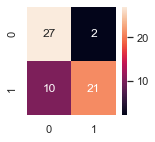

In [124]:
acc_feat_sel(feat,ndf,ndft,Bayes,'Bayes')

### Perceptron Accuracy feature selection

In [125]:
feat = fet_sel_acc(ndf,ndft,Perceptron,'Perceptron',0.65)

Test Set Accuracy = 0.75
 F1 Score = 0.7457627118644068

Confusion Matrix


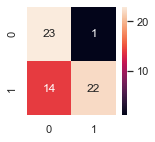

In [126]:
acc_feat_sel(feat,ndf,ndft,Perceptron,'Perceptron')

In [127]:
cols = pcc_fea_sel(ndf,0.33)

dfn = ndf[cols]
dfnt = ndft[cols]

dfsn = dfn.values
Xn = dfn.iloc[:,:-1].values
yn = dfn.iloc[:,-1].values
zn = get_z(yn)
Xtn = dfnt.iloc[:,:-1].values
ytn = dfnt.iloc[:,-1].values

### N means Pearson feature selection

Test Set Accuracy = 0.7166666666666667
 F1 Score = 0.7017543859649124

Confusion Matrix


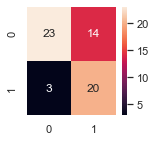

In [128]:
yhnme = nmeans(Xn,yn,Xtn)
scores(ytn,yhnme,'Test Set')

### Perceptron Pearson feature selection

Test Set Accuracy = 0.65
 F1 Score = 0.6769230769230768

Confusion Matrix


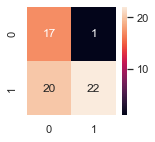

In [129]:
yhpc = Perceptron(dfsn,Xtn)
scores(yhpc,ytn,'Test Set')

## Standardiation

In [130]:
sdf = dfex.iloc[:]
for i in dfex.columns:
    if i == 'Date' or i == 'Classes':
        continue
    sdf[i] = (dfex[i]-dfex[i].mean())/(dfex[i].std())

In [131]:
sdft = dfext[:]
for i in dfext.columns:
    if i == 'Date' or i == 'Classes':
        continue
    sdft[i] = (dfext[i]-dfext[i].mean())/(dfext[i].std())

### N means Accuracy feature selection

In [132]:
feat = fet_sel_acc(sdf,sdft,nmeans,'nmeans',0.65)

Test Set Accuracy = 0.85
 F1 Score = 0.8085106382978724

Confusion Matrix


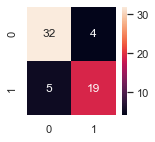

In [133]:
acc_feat_sel(feat,sdf,sdft,nmeans,'nmeans')

### Bayes Accuracy feature selection

In [134]:
feat = fet_sel_acc(sdf,sdft,Bayes,'Bayes',0.65)

Test Set Accuracy = 0.8
 F1 Score = 0.7931034482758621

Confusion Matrix


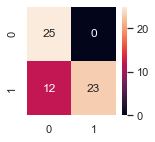

In [135]:
acc_feat_sel(feat,sdf,sdft,Bayes,'Bayes')

### Perceptron Accuracy selection

In [136]:
feat = fet_sel_acc(sdf,sdft,Perceptron,'Perceptron',0.65)

Test Set Accuracy = 0.7666666666666667
 F1 Score = 0.75

Confusion Matrix


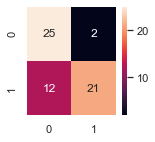

In [137]:
acc_feat_sel(feat,sdf,sdft,Perceptron,'Perceptron')

In [138]:
cols = pcc_fea_sel(sdf,0.33)

dfn = sdf[cols]
dfnt = sdft[cols]

dfsn = dfn.values
Xn = dfn.iloc[:,:-1].values
yn = dfn.iloc[:,-1].values
zn = get_z(yn)
Xtn = dfnt.iloc[:,:-1].values
ytn = dfnt.iloc[:,-1].values

### N means Pearson feature selection

Test Set Accuracy = 0.7333333333333333
 F1 Score = 0.7142857142857143

Confusion Matrix


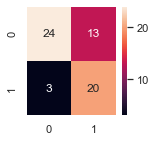

In [139]:
yhnme = nmeans(Xn,yn,Xtn)
scores(ytn,yhnme,'Test Set')

### Perceptron Pearson selection

Test Set Accuracy = 0.7166666666666667
 F1 Score = 0.721311475409836

Confusion Matrix


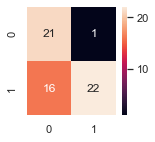

In [140]:
yhpc = Perceptron(dfsn,Xtn)
scores(yhpc,ytn,'Test Set')

As we can see normalizing or standardizing the best models reduced the accuracy so I would not be performing those tweaks.

# Summary

In [141]:
vcv = [[0.933,0.955,0.933,0.955,0.866,0.933],[0.964,0.976,0.962,0.976,0.923,0.964]]
dvcv=pd.DataFrame(vcv, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
tcv = [[0.8,0.866,0.833,0.833,0.516,0.8],[0.739,0.84,0.744,0.756,0.597,0.76]]
dtcv = pd.DataFrame(tcv, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
t = [[0.783,0.866,0.85,0.866,0.783,0.833],[0.628,0.846,0.808,0.755,0.666,0.807]]
dt = pd.DataFrame(t, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
vcve = [[0.928,'na',0.57,0.714,0.692,0.928],[0.962,'na',0.916,0.833,0.782,0.962]]
dvcve = pd.DataFrame(vcve, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
tcve = [[0.816,'na',0.816,0.483,0.716,0.833],[0.744,'na',0.784,0.311,0.585,0.799]]
dtcve = pd.DataFrame(tcve, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
te = [[0.8,0.416,0.866,0.45,0.45,0.85],[0.684,0.567,0.84,0.326,0.297,0.823]]
dte = pd.DataFrame(te, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
pc = [[0.833,0.75,0.916,0.95,0.233,0.783],[.75,0.666,0.888,0.92,0.206,0.763]]
dpc = pd.DataFrame(pc, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
afs = [[0.833,0.883,0.8,0.616,0.5,0.783],[0.75,0.844,0.749,0.0,0.399,0.711]]
dafs = pd.DataFrame(afs, columns=['N means','Bayes','Perceptron','MSE','SVM Linear','SVM RBF'],index=['Accuracy','F1 Score'])
nor = [[0.816,0.8,0.85,0.716,0.716],[0.755,0.777,0.823,0.701,0.730]]
dnor = pd.DataFrame(nor, columns=['N means Acc','Bayes Acc','Perceptron Acc','N means Pea','Perceptron Pea'],index=['Accuracy','F1 Score'])
std = [[0.85,0.8,0.766,0.733,0.733],[0.808,0.793,0.766,0.714,0.733]]
dstd = pd.DataFrame(std, columns=['N means Acc','Bayes Acc','Perceptron Acc','N means Pea','Perceptron Pea'],index=['Accuracy','F1 Score'])

## Below is the accuracy and F1 score I have got for various models, for various tuning and parameters

### Validation Set accoracy and F1 score on base dataset

In [142]:
dvcv

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.933,0.955,0.933,0.955,0.866,0.933
F1 Score,0.964,0.976,0.962,0.976,0.923,0.964


### Test set accuracy and F1 score after spliting into train and validation set

In [143]:
dtcv

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.800,0.866,0.833,0.833,0.516,0.80
F1 Score,0.739,0.840,0.744,0.756,0.597,0.76


### Test Set accuracy and f1 score after training on entire train set (no split)

In [144]:
dt

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.783,0.866,0.850,0.866,0.783,0.833
F1 Score,0.628,0.846,0.808,0.755,0.666,0.807


### Validation set accuracy and f1 score after expanding feature set

In [145]:
dvcve

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.928,na,0.570,0.714,0.692,0.928
F1 Score,0.962,na,0.916,0.833,0.782,0.962


### Test set accuracy and F1 score after spliting into train and validation set ,expanded feature set

In [146]:
dtcve

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.816,na,0.816,0.483,0.716,0.833
F1 Score,0.744,na,0.784,0.311,0.585,0.799


### Test Set accuracy and f1 score after training on entire train set (no split) expanded feature set

In [147]:
dte

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.800,0.416,0.866,0.450,0.450,0.850
F1 Score,0.684,0.567,0.840,0.326,0.297,0.823


### After Pearsons corelation feature selection

In [148]:
dpc

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.833,0.750,0.916,0.95,0.233,0.783
F1 Score,0.750,0.666,0.888,0.92,0.206,0.763


### After Accuracy based feature selection

In [149]:
dafs

,N means,Bayes,Perceptron,MSE,SVM Linear,SVM RBF
Accuracy,0.833,0.883,0.800,0.616,0.500,0.783
F1 Score,0.750,0.844,0.749,0.000,0.399,0.711


### After normalizing best models

In [150]:
dnor

,N means Acc,Bayes Acc,Perceptron Acc,N means Pea,Perceptron Pea
Accuracy,0.816,0.800,0.850,0.716,0.716
F1 Score,0.755,0.777,0.823,0.701,0.730


### After standardizing best models

In [151]:
dstd

,N means Acc,Bayes Acc,Perceptron Acc,N means Pea,Perceptron Pea
Accuracy,0.850,0.800,0.766,0.733,0.733
F1 Score,0.808,0.793,0.766,0.714,0.733


The highest accuracy attained was on the MSE model after pearsons corelation based feature selection at 95%, but I achieved this only once and the model is not reliable due to the random shuffle used for sequential gradient descent. The same thing goes for the Perceptron model based on pearson feature selection, though it is more reliavle and gives accuracy of about 89-90% most of the times, it is still unpredictable. So I would choose the Bayes model using the accuracy feature selection where min accuracy required is 65%, with this model I got an accuracy of 88.33% and is the most reliable.

### Best Accuracy ever achieved 95% MSE (LMS algorithm) model using pearsons corelation feature selection with threshold 0.33 or 0.5, using eta = a/(b+1) for constant a = 0.01 and b = [0.01,0.1,1,10,100,1000]. But in reliable and doesn't give consistent results.


### Best and Most reliable model is the Bayes model with accracy based feature selection > 0.65, without normalizing or standardizing

### Accuracy = 88.33% F1 score = 0.8444